In [1]:
import warnings
warnings.filterwarnings("ignore")

import gc
import numpy as np 
import pandas as pd
import datetime as dt

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans

import folium
import geopandas as gpd
from haversine import haversine

import optuna
import xgboost as xgb

from sklearn.ensemble import RandomForestRegressor

pd.set_option('display.max_columns', None)

# Read files
path = '/kaggle/input/playground-series-s3e20/'
train = pd.read_csv(path+'train.csv')
test = pd.read_csv(path+'test.csv')
ss = pd.read_csv(path+'sample_submission.csv')

bold = ['\033[1m', '\033[0m']
seed = 228

![](https://yesofcorsa.com/wp-content/uploads/2018/04/Rwanda-Wallpaper-Download-Free.jpg)
<a href="https://yesofcorsa.com/rwanda/"><small>Picture source</small></a>

<b><span style='color:#505160;font-size:200%'>|</span><span style='color:#ffbb00;font-size:200%;font-family:calibri'> Missing values</span></b>

<p style="text-align:justify;">
There are a lot of missing values in the data, but this is not important for us, since only a few main features are needed to get the best result both in cross-validation and in the leaderboard.
</p>

In [2]:
def mv(df_train, df_test, tr_name, te_name):
    l_tr = len(df_train)
    l_te = len(df_test)
    
    df_train = df_train.isna().sum().to_frame().reset_index() \
                .rename({'index': 'Column', 0: tr_name}, axis=1).drop(75)
    df_test = df_test.isna().sum().to_frame().reset_index() \
                .rename({'index': 'Column', 0: te_name}, axis=1)
    
    df_train[tr_name] = round(df_train[tr_name]/l_tr*100, 2)
    df_test[te_name] = round(df_test[te_name]/l_te*100, 2)
    
    df_train[te_name] = df_test[te_name]
    return df_train

def highlight_nan(val, color_nan, color_):
    if val > 0:
        return f'color: {color_nan}; font-weight: bold'
    else:
        return f'color: {color_}'
    
df_mv = mv(train, test, 'train data, %', 'test data, %')
df_mv = df_mv.style.hide_index().set_table_styles(
    [
        {
            'selector': 'th.col_heading', 
            'props': 'font-size: 12pt; text-align: center; font-weight: bold; border: 1px solid black !important'
        },
        {
            'selector': 'td', 
            'props': 'text-align: center; font-size: 10pt; border: 1px solid black !important'
        },
        {
            'selector': 'th:not(.index_name)', 
            'props': 'background-color: #ffbb00; color: white;'
        }
    ], overwrite=False) \
.set_properties(subset=['Column'], **{'font-weight': 'bold'}) \
.applymap(highlight_nan, 
          color_nan='#8d230f', 
          color_='#00293c', 
          subset=['train data, %', 'test data, %']) \
.set_precision(2)

display(df_mv)

Column,"train data, %","test data, %"
ID_LAT_LON_YEAR_WEEK,0.00,0.00
latitude,0.00,0.00
longitude,0.00,0.00
year,0.00,0.00
week_no,0.00,0.00
SulphurDioxide_SO2_column_number_density,18.49,25.22
SulphurDioxide_SO2_column_number_density_amf,18.49,25.22
SulphurDioxide_SO2_slant_column_number_density,18.49,25.22
SulphurDioxide_cloud_fraction,18.49,25.22
SulphurDioxide_sensor_azimuth_angle,18.49,25.22


<b><span style='color:#505160;font-size:200%'>|</span><span style='color:#ffbb00;font-size:200%;font-family:calibri'> Preprocessing</span></b>

<p style="text-align:justify;">
The model is built based on the date, coordinates and 'Ozone_solar_azimuth_angle'. Of the many physico-chemical indicators, the best, based on my check, is 'Ozone_solar_azimuth_angle'. This is very strange, but when adding other indicators, the results of cross-validation deteriorate.
</p>

In [3]:
def get_id(row):
    return int(''.join(filter(str.isdigit, str(row['latitude']))) + ''.join(filter(str.isdigit, str(row['longitude']))))

train['id'] = train[['latitude', 'longitude']].apply(lambda row: get_id(row), axis=1)
test['id'] = test[['latitude', 'longitude']].apply(lambda row: get_id(row), axis=1)
new_ids = {id_: new_id for new_id, id_ in enumerate(train['id'].unique())}
train['id'] = train['id'].map(new_ids)
test['id'] = test['id'].map(new_ids)

rwanda_center = (-1.9607, 29.9707)
park_biega = (-1.8866, 28.4518) 
kirumba = (-0.5658, 29.1714) 
massif = (-2.9677, 28.6469)
lake = (-1.9277, 31.4346)
mbarara = (-0.692, 30.602)
muy = (-2.8374, 30.3346)

def cluster_features(df, cluster_centers):
    for i, cc in enumerate(cluster_centers.values()):
        df[f'cluster_{i}'] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), cc, unit='ft'), axis=1)
    return df

def get_month(row):
    date = dt.datetime.strptime(f'{row["year"]}-{row["week_no"]+1}-1', "%Y-%W-%w")
    return date.month

def coor_rotation(df):
    df['rot_15_x'] = (np.cos(np.radians(15)) * df['longitude']) + \
                     (np.sin(np.radians(15)) * df['latitude'])
    
    df['rot_15_y'] = (np.cos(np.radians(15)) * df['latitude']) + \
                     (np.sin(np.radians(15)) * df['longitude'])

    df['rot_30_x'] = (np.cos(np.radians(30)) * df['longitude']) + \
                     (np.sin(np.radians(30)) * df['latitude'])

    df['rot_30_y'] = (np.cos(np.radians(30)) * df['latitude']) + \
                     (np.sin(np.radians(30)) * df['longitude'])
    return df
    
y = train['emission']

def preprocessing(df):
    
    cols_save = ['id', 'latitude', 'longitude', 'year', 'week_no', 'Ozone_solar_azimuth_angle']
    df = df[cols_save]
    
    good_col = 'Ozone_solar_azimuth_angle'
    df[good_col] = df.groupby(['id', 'year'])[good_col].ffill().bfill()
    df[f'{good_col}_lag_1'] = df.groupby(['id', 'year'])[good_col].shift(1).fillna(0)
    
    df = coor_rotation(df)
    
    for col, coors in zip(
        ['dist_rwanda', 'dist_park', 'dist_kirumba', 'dist_massif', 'dist_lake', 'dist_mbarara', 'dist_muy'], 
        [rwanda_center, park_biega, kirumba, massif, lake, mbarara, muy]
    ):
        df[col] = df.apply(lambda x: haversine((x['latitude'], x['longitude']), coors, unit='ft'), axis=1)
    
    df['month'] = df[['year', 'week_no']].apply(lambda row: get_month(row), axis=1)
    df['is_covid'] = (df['year'] == 2020) & (df['month'] > 2) | (df['year'] == 2021) & (df['month'] == 1)
    df['is_lockdown'] = (df['year'] == 2020) & ((df['month'].isin([3,4])))
    df['is_covid_peak'] = (df['year'] == 2020) & ((df['month'].isin([4,5,6])))
    df['is_covid_dis_peak'] = (df['year'] == 2021) & ((df['month'].isin([7,8,9])))
    df['public_holidays'] = (df['week_no'].isin([0, 51, 12, 30]))
    
#     df['high_em'] = (df['week_no'].between(14, 17)) | (df['week_no'].between(40, 43)) 
            
    df.fillna(0, inplace=True)
    return df
    
train = preprocessing(train)
test = preprocessing(test)

df = pd.concat([train, test], axis=0, ignore_index=True)
coordinates = df[['latitude', 'longitude']].values
clustering = KMeans(n_clusters=12, max_iter=1000, random_state=seed).fit(coordinates)
cluster_centers = {i: tuple(centroid) for i, centroid in enumerate(clustering.cluster_centers_)}
df = cluster_features(df, cluster_centers)

countries = pd.read_csv('/kaggle/input/ps3e20-coordinates-countries/countries.csv')
countries.loc[countries['country']=='République démocratique du Congo', 'country'] = 'Congo'
df = df.merge(countries[['id', 'country']], on='id', how='left')
le = LabelEncoder()
df['country'] = le.fit_transform(df['country'])
df = pd.concat([df, pd.get_dummies(df['country'], prefix='country')], axis=1)
df.drop('country', axis=1, inplace=True)

train = df.iloc[:-len(test),:]
test = df.iloc[-len(test):,:]
del df

X = train.drop('id', axis=1)
test = test.drop('id', axis=1)

<b><span style='color:#505160;font-size:200%'>|</span><span style='color:#ffbb00;font-size:200%;font-family:calibri'> Observations by country</span></b>

<p style="text-align:justify;">
We predict emissions in Rwanda with only 32% of observations from Rwanda itself. It is also worth noting that the Congo has the lowest amount of emissions, while Rwanda has the highest. What is even more interesting is that there are 12 places in Congo where level of emission is consistently zero, 2 in Burundi and 1 in Tanzania.
</p>

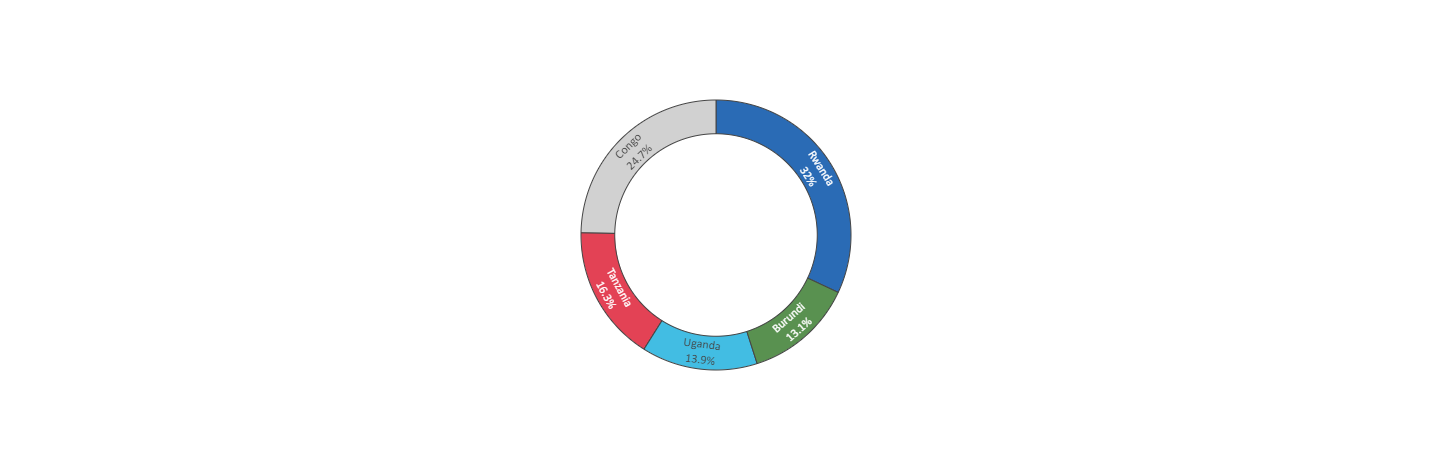

In [4]:
info = countries['country'].value_counts().reset_index()
fig = go.Figure()
fig.add_trace(
    go.Pie(
        labels=info['index'],
        values=info['country'],
        textinfo='label+percent',
        textposition = 'inside',
        hoverinfo='value',
        textfont_size=22,
        marker=dict(
            colors=['#2a6bb5', '#d1d1d1', '#e34255', '#42bde3', '#599150'], 
            line=dict(color='#444444', width=1)
        ),
        hole=0.75,
        showlegend=False
    )
)

fig.update_layout(
    width=750, 
    height=450, 
    plot_bgcolor='white',
    font_family='Calibri', 
    font_color='#444444',
    hoverlabel=dict(font_size=14, font_family='Calibri')
)

fig.show()

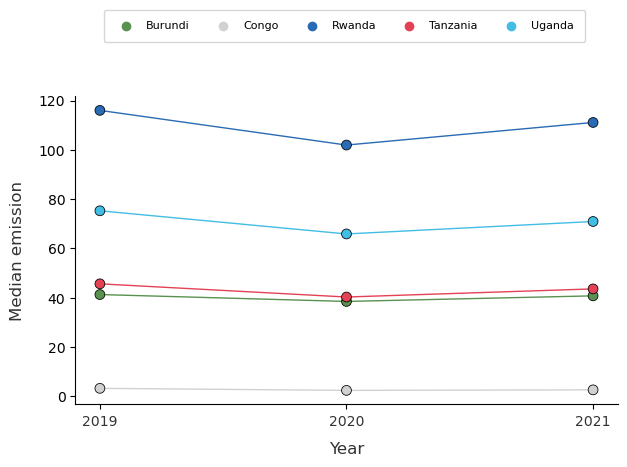

In [5]:
df_plot = train[['id', 'year', 'month', 'is_covid', 'week_no']]
df_plot['emission'] = y
df_plot = df_plot.merge(countries[['id', 'country']], on='id', how='left')
df_plot_year = df_plot.groupby(['id', 'year'], as_index=False)['emission'].mean()
df_plot_year = df_plot_year.merge(df_plot[['id', 'country']].drop_duplicates(), on=['id'], how='left')
info = df_plot_year.groupby(['country', 'year'], as_index=False)['emission'].median()

fig = plt.figure(figsize=(7, 4))
a = sns.lineplot(
    data=info, 
    x='year', 
    y='emission', 
    hue='country',
    palette=['#599150', '#d1d1d1', '#2a6bb5', '#e34255', '#42bde3'], 
    linewidth=1,
    legend=False
)

sns.scatterplot(
    data=info, 
    x='year', 
    y='emission', 
    hue='country',
    palette=['#599150', '#d1d1d1', '#2a6bb5', '#e34255', '#42bde3'], 
    s=50, 
    edgecolor='black', 
    zorder=5
)

plt.xlabel('Year', size=12, color='#313233', labelpad=10)
plt.xticks(np.array([2019, 2020, 2021]), size=10, color='#313233')
plt.ylabel('Median emission', size=12, color='#313233', labelpad=10)
plt.legend(bbox_to_anchor=(0.95, 1.3), ncol=5, borderpad=1, fontsize=8)

for j in ['right', 'top']:
    a.spines[j].set_visible(False)
    
plt.show()

<b><span style='color:#505160;font-size:200%'>|</span><span style='color:#ffbb00;font-size:200%;font-family:calibri'> Covid's impact and time of big emissions</span></b>

<p style="text-align:justify;">
I selected first 10 IDs from each country to assess how they were affected by covid, as well as to assess the impact of emissions at ~14-17 and ~40-43 weeks of each year. The second red zone is the second peak of diseases. With covid everything is clear, but what attracts more attention - the weeks of high emissions. They are most significant in Rwanda and Burundi, which occupy 45% of all observations. Also on these dates, minor emissions are observed in Uganda. Adding weeks with big emissions as features incredibly improves CV score - I get CV 17.92 with XGB, but there is a big deterioration in the leaderboard. I am convinced that there is a right way to use this information to get the best result, but I have not found it yet.
</p>

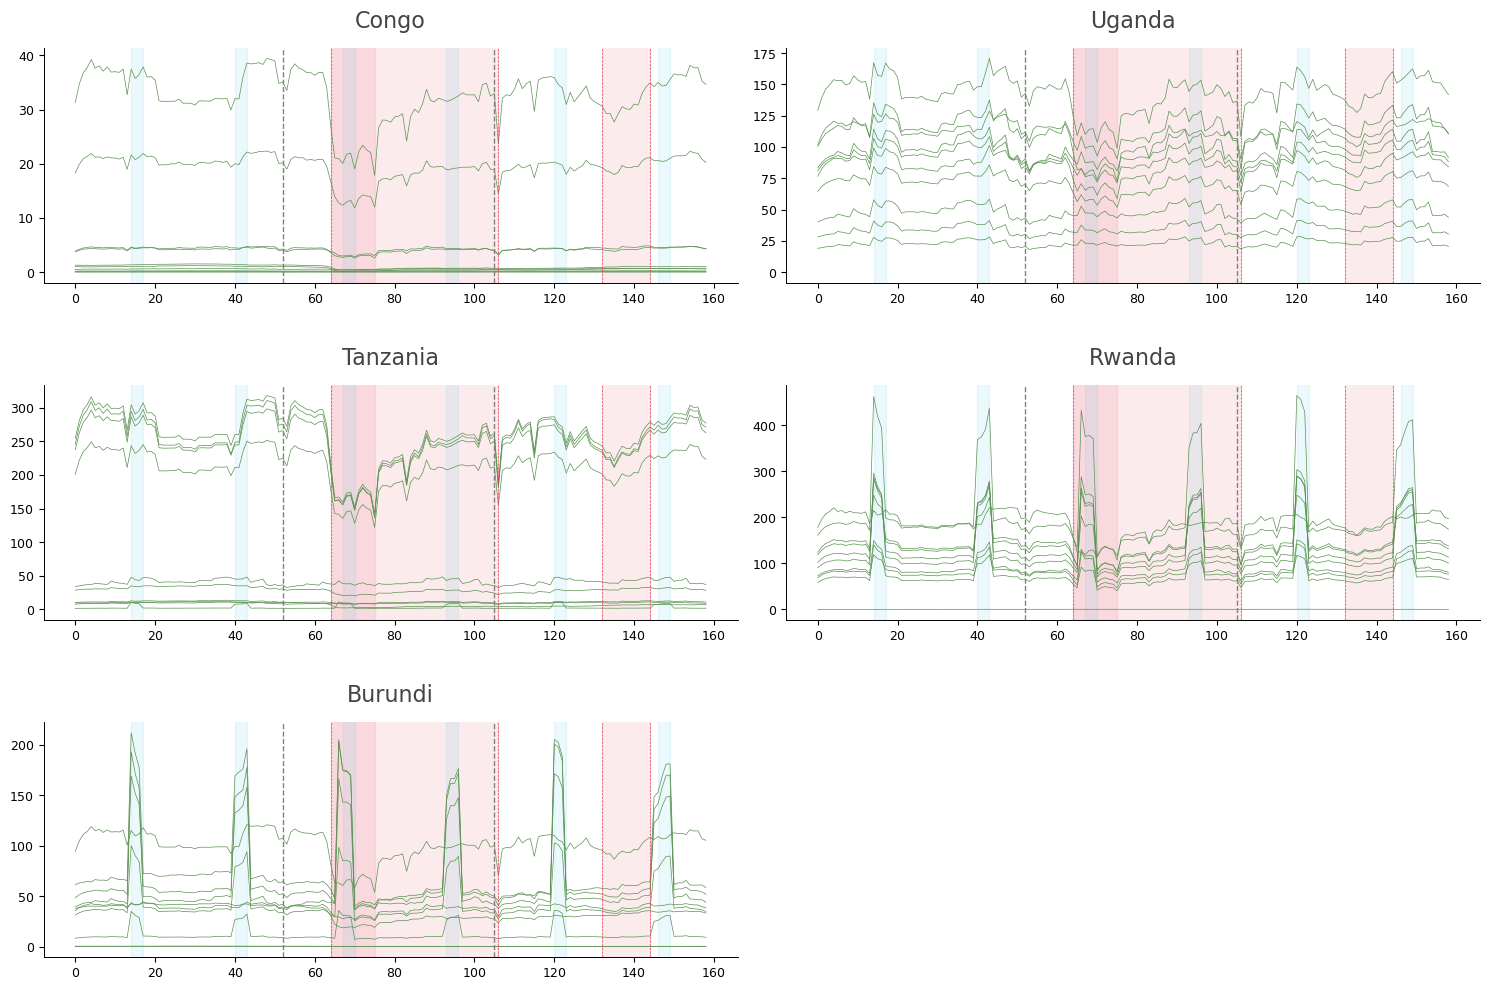

In [6]:
df_plot['n_observ'] = df_plot.groupby('id').cumcount()

fig = plt.figure(figsize=(15, 10))
for i, country in enumerate(countries['country'].unique()):
    plt.subplot(3,2,i+1)
    plt.title(
        country, 
        size=16, 
        y=1.05, 
        fontname='Calibri', 
        color='#444444'
    )
    
    ids = df_plot[df_plot['country']==country].drop_duplicates(subset=['id'])['id'][:10].tolist()
    for id_ in ids:
        a = sns.lineplot(
            data=df_plot[df_plot['id']==id_], 
            x='n_observ', 
            y='emission', 
            color='#599150', 
            linewidth=0.5
        )
        
    plt.axvline(np.array([52]), linestyle='--', color='gray', linewidth=1) # end of 2019
    plt.axvline(np.array([105]), linestyle='--', color='gray', linewidth=1) # end of 2020
        
    plt.axvline(np.array([64]), linestyle='--', color='#e34255', linewidth=0.5) # covid
    plt.axvline(np.array([106]), linestyle='--', color='#e34255', linewidth=0.5)
    
    for n in [[64, 107], [64, 76]]: # covid, lockdown
        a.fill_between(
            x=np.arange(n[0], n[1]), 
            y1=0, 
            y2=int(df_plot[df_plot['id'].isin(ids)]['emission'].max()), 
            color='#e34255', 
            alpha=0.1, 
            transform=a.get_xaxis_transform()
        )
        
    plt.axvline(np.array([132]), linestyle='--', color='#e34255', linewidth=0.5) # covid diseases peak
    plt.axvline(np.array([144]), linestyle='--', color='#e34255', linewidth=0.5)
    a.fill_between(
        x=np.arange(132, 145), 
        y1=0, 
        y2=int(df_plot[df_plot['id'].isin(ids)]['emission'].max()), 
        color='#e34255', 
        alpha=0.1, 
        transform=a.get_xaxis_transform()
    )
    
    for n in [[14, 17], [67, 70], [120, 123], [40, 43], [93, 96], [146, 149]]:
        a.fill_between(
            x=np.arange(n[0], n[1]+1), 
            y1=0, 
            y2=int(info[info['country']==country]['emission'].max()), 
            color='#42bde3', 
            alpha=0.1, 
            transform=a.get_xaxis_transform()
        )
    
    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xlabel('')
    plt.ylabel('')
    
    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
    for j in ['left', 'bottom']:    
        a.spines[j].set_linewidth(0.7)
        

fig.tight_layout(h_pad=3)
plt.show()

<p style="text-align:justify;">
Now let's take a look at the median values in each country. The interesting thing here is that the median values in Uganda, Tanzania and Burundi, although different, but they have the same places of falls and places of growth.

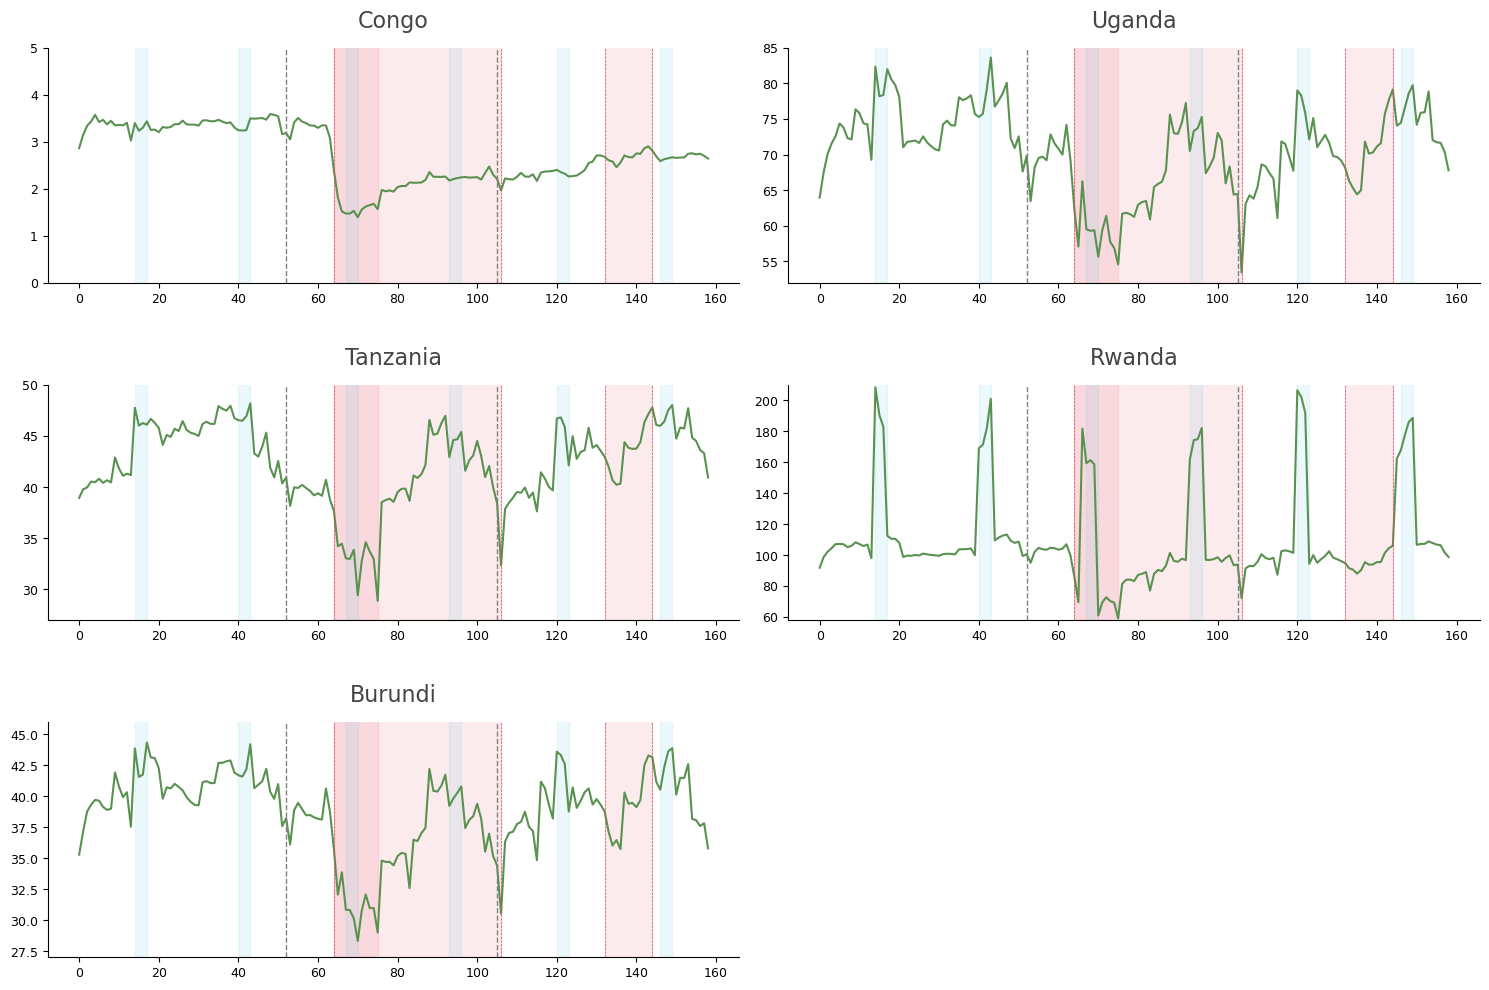

In [7]:
info = df_plot.groupby(['country', 'n_observ'], as_index=False)['emission'].median()

fig = plt.figure(figsize=(15, 10))
for i, country in enumerate(countries['country'].unique()):
    plt.subplot(3,2,i+1)
    plt.title(
        country, 
        size=16, 
        y=1.05, 
        fontname='Calibri', 
        color='#444444'
    )
    
    a = sns.lineplot(
        data=info[info['country']==country], 
        x='n_observ', 
        y='emission', 
        color='#599150', 
        linewidth=1.5
    )
    
    plt.axvline(np.array([52]), linestyle='--', color='gray', linewidth=1) # end of 2019
    plt.axvline(np.array([105]), linestyle='--', color='gray', linewidth=1) # end of 2020
        
    plt.axvline(np.array([64]), linestyle='--', color='#e34255', linewidth=0.5) # covid
    plt.axvline(np.array([106]), linestyle='--', color='#e34255', linewidth=0.5)
    
    for n in [[64, 106], [64, 75]]: # covid, lockdown
        a.fill_between(
            x=np.arange(n[0], n[1]+1), 
            y1=0, 
            y2=int(info[info['country']==country]['emission'].max()), 
            color='#e34255', 
            alpha=0.1, 
            transform=a.get_xaxis_transform()
        )
        
    plt.axvline(np.array([132]), linestyle='--', color='#e34255', linewidth=0.5) # covid diseases peak
    plt.axvline(np.array([144]), linestyle='--', color='#e34255', linewidth=0.5)
    a.fill_between(
        x=np.arange(132, 145), 
        y1=0, 
        y2=int(info[info['country']==country]['emission'].max()), 
        color='#e34255', 
        alpha=0.1, 
        transform=a.get_xaxis_transform()
    )
    
    for n in [[14, 17], [67, 70], [120, 123], [40, 43], [93, 96], [146, 149]]:
        a.fill_between(
            x=np.arange(n[0], n[1]+1), 
            y1=0, 
            y2=int(info[info['country']==country]['emission'].max()), 
            color='#42bde3', 
            alpha=0.1, 
            transform=a.get_xaxis_transform()
        )
    
    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
        
    a.set_ylim(
        int(info[info['country']==country]['emission'].min())-1, 
        int(info[info['country']==country]['emission'].max())+2
    )
    
    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xlabel('')
    plt.ylabel('')

fig.tight_layout(h_pad=3)
plt.show()

<b><span style='color:#505160;font-size:200%'>|</span><span style='color:#ffbb00;font-size:200%;font-family:calibri'> Map visualization</span></b>

<p style="text-align:justify;">
The main code of visualization is taken from the Ambrosm's <a href="https://www.kaggle.com/code/ambrosm/pss3e20-eda-which-makes-sense">work</a>. I have added 5 key points, the distance to which has a great importance: center of Rwanda, point near lake Victoria, 3 poins on West where vegetation prevails in Congo, Muyinga in Burundi and Mbarara in Uganda.
</p>

In [8]:
train['emission'] = y
train_coords = train.drop_duplicates(subset = ['latitude', 'longitude'])
geometry = gpd.points_from_xy(train_coords['longitude'], train_coords['latitude'])
geo_df = gpd.GeoDataFrame(train_coords[["latitude", "longitude"]], geometry=geometry)

all_data_map = folium.Map(prefer_canvas=True)
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geo_df.geometry]

def rgba_to_hex(color):
    red, green, blue, alpha = color
    return f"#{int(red*255):02x}{int(green*255):02x}{int(blue*255):02x}"

temp = train.groupby(['latitude', 'longitude']).emission.mean().reset_index()
geometry = gpd.points_from_xy(temp['longitude'], temp['latitude'])

cmap = matplotlib.colormaps['coolwarm']
normalizer = matplotlib.colors.Normalize(vmin=np.log1p(temp['emission'].min()), vmax=np.log1p(temp['emission'].max()))

all_data_map = folium.Map(prefer_canvas=True)
geo_df_list = [[point.xy[1][0], point.xy[0][0]] for point in geometry]

for coordinates, emission in zip(geo_df_list, temp['emission']):
    all_data_map.add_child(
        folium.CircleMarker(
            location=coordinates,
            radius=1,
            weight=4,
            zoom=10,
            color=rgba_to_hex(cmap(normalizer(np.log1p(emission))))),
        )
all_data_map.fit_bounds(all_data_map.get_bounds())

for color, coors in zip(
    ['red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue'], 
    [rwanda_center, park_biega, kirumba, massif, lake, mbarara, muy]
):
    all_data_map.add_child(
        folium.features.CircleMarker(
            coors, 
            radius=8,
            color=color,
            fill_color=color
        )
    )

all_data_map

<b><span style='color:#505160;font-size:200%'>|</span><span style='color:#ffbb00;font-size:200%;font-family:calibri'> Cartesian coordinates rotation</span></b>

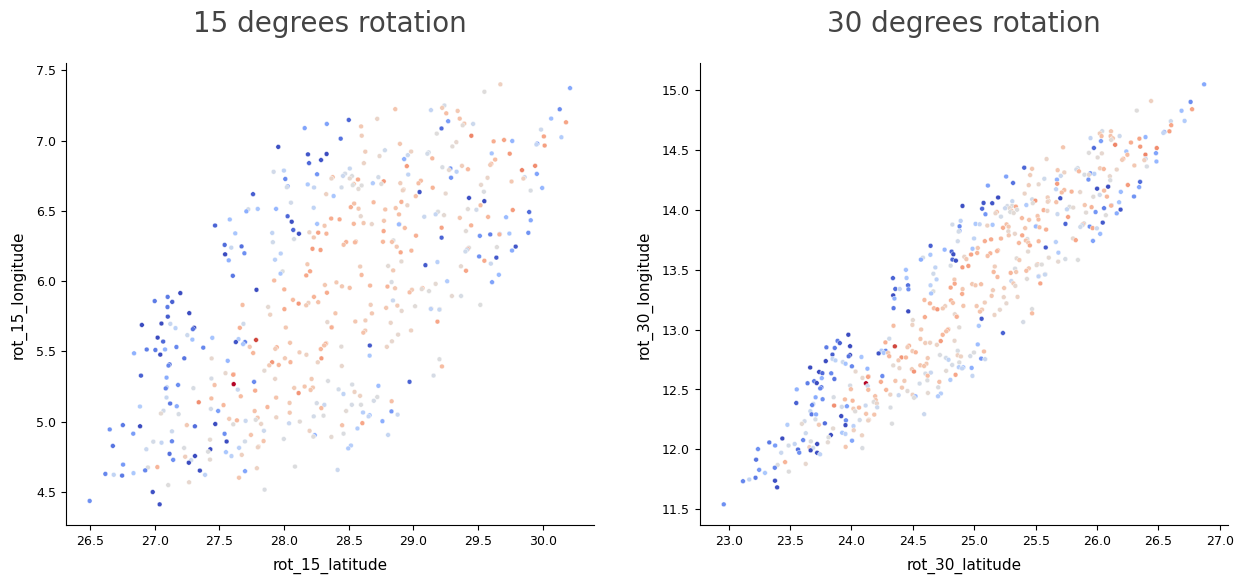

In [9]:
train['emission'] = y
df_mean = train.groupby('id', as_index=False)['emission'].mean()
df_mean = df_mean.merge(train.drop_duplicates(subset=['id'])[['id', 'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y']], on='id', how='left')
df_mean['log_em'] = np.log1p(df_mean['emission'])

fig = plt.figure(figsize=(15, 6))
for i, col in enumerate(['15', '30']):
    plt.subplot(1,2,i+1)
    plt.title(
        f'{col} degrees rotation', 
        size=20, 
        y=1.05, 
        fontname='Calibri', 
        color='#444444'
    )
    a = sns.scatterplot(
        data=df_mean, 
        x=f'rot_{col}_x', 
        y=f'rot_{col}_y', 
        hue='log_em', 
        palette='coolwarm', 
        s=12
    )
    plt.xticks(size=9)
    plt.yticks(size=9)
    plt.xlabel(f'rot_{col}_latitude', labelpad=7, fontsize=11)
    plt.ylabel(f'rot_{col}_longitude', labelpad=7, fontsize=11)

    for j in ['right', 'top']:
        a.spines[j].set_visible(False)
    a.get_legend().remove()
    
plt.show()

train.drop('emission', axis=1, inplace=True)

<b><span style='color:#505160;font-size:200%'>|</span><span style='color:#ffbb00;font-size:200%;font-family:calibri'> Check CV RMSE with XGB</span></b>

<p style="text-align:justify;">
The result of the XGB model with the created features already has an excellent result - CV 19.3, however, for prediction I will use simple RandomForest. The result of the XGB code is missing, because for the fastest learning RF training with a large number of trees, full CPU power is required.
</p>

In [10]:
# logo = LeaveOneGroupOut()

# def rmse(predictions, targets):
#     return np.sqrt(((predictions - targets) ** 2).mean())

# xgb_params = {
#     'max_depth': 6,
#     'eta': 0.01,
#     'colsample_bytree': 0.66,
#     'subsample': 0.76,
#     'min_child_weight': 2,
#     'lambda': 1, 
#     'gamma': 1,
    
#     'tree_method': 'gpu_hist',
#     'booster': 'gbtree',
#     'predictor':'gpu_predictor',
#     'seed': seed,
#     'objective': 'reg:squarederror',
#     'eval_metric': 'rmse'
# }

# scores = []
# for fold, (train_idx, val_idx) in enumerate(logo.split(X, y, X['year'])):

#     dtrain = xgb.DMatrix(
#         X.iloc[train_idx], 
#         label=y.iloc[train_idx]
#     )
#     dvalid = xgb.DMatrix(
#         X.iloc[val_idx], 
#         label=y.iloc[val_idx]
#     )

#     model = xgb.train(
#         params=xgb_params, 
#         dtrain=dtrain, 
#         num_boost_round=50000,
#         evals=[(dvalid, 'eval')], 
#         verbose_eval=500,
#         callbacks=[
#             xgb.callback.EarlyStopping(
#                 rounds=500,
#                 data_name='eval',
#                 maximize=False,
#                 save_best=True
#             )
#         ]
#     )
    
#     val_preds = model.predict(dvalid)
#     val_score = rmse(y.iloc[val_idx], val_preds)
#     scores.append(val_score)
#     print(f'FOLD {fold+1} RMSE: {bold[0]}{round(val_score, 6)}{bold[1]}')
    
#     del dtrain, dvalid, val_preds, val_score, model
#     gc.collect()

# print(f'\nCV RMSE: {bold[0]}{round(np.mean(scores), 6)}{bold[1]}')

<b><span style='color:#505160;font-size:200%'>|</span><span style='color:#ffbb00;font-size:200%;font-family:calibri'> Make predictions with simple RF</span></b>

<p style="text-align:justify;">
I use mixing of two models trained on different features. This improves the result. In addition, it is worth considering the important findings of Chun Fu in his <a href="https://www.kaggle.com/code/patrick0302/find-and-fix-the-error-bug">work</a> and Random Draw in his <a href="https://www.kaggle.com/code/danbraswell/no-ml-public-lb-23-02231">work</a> - the objects with high emissions require an "individual" approach. Also, after a while, it became clear to many participants that no matter how sad it was, the competition turned into an experimental divination "what if ...", where ML models show bad results. I will still stick to at least combining model prediction with manual data post-processing
</p>

In [11]:
final_preds = np.zeros(len(test))
train['emission'] = y

rf = RandomForestRegressor(n_estimators=3000, random_state=seed, n_jobs=-1)
rf.fit(X, y)
final_preds += rf.predict(test) * 0.35

del rf

base_cols = [
    'latitude', 'longitude', 'year', 'week_no', 
    'rot_15_x', 'rot_15_y', 'rot_30_x', 'rot_30_y', 
    'dist_rwanda', 'month'
]

rf = RandomForestRegressor(n_estimators=3000, random_state=seed, n_jobs=-1)
rf.fit(X[base_cols], y)
final_preds += rf.predict(test[base_cols]) * 0.65

del rf
gc.collect()

ss['emission'] = final_preds * 1.07
ss['id'] = np.array(train[(train['week_no']<49)&(train['year']==2021)]['id'])
ss['week_no'] = ss.groupby('id').cumcount()
ss.loc[ss['id']==293, 'emission'] = np.array(train[(train['id']==293)&(train['year']==2021)&(train['week_no']<49)]['emission'])
ss['emission'] = ss['emission']*0.35 + np.max([train[(train['year']==y) & (train['week_no']<49)]['emission'] for y in range(2019, 2022)], axis=0)*0.65

# Thanks for the results https://www.kaggle.com/code/patrick0302/align-2019-2020-emission-values-with-2021
ss2 = pd.read_csv('/kaggle/input/ps3e20-preds/ss2132.csv')
ss['emission'] = (ss['emission'] + ss2['emission']) / 2

ss.drop(['id', 'week_no'], axis=1, inplace=True)
ss.to_csv('submission.csv', index=False)
ss

,ID_LAT_LON_YEAR_WEEK,emission
0,ID_-0.510_29.290_2022_00,4.004916
1,ID_-0.510_29.290_2022_01,4.277571
2,ID_-0.510_29.290_2022_02,4.375822
3,ID_-0.510_29.290_2022_03,4.414508
4,ID_-0.510_29.290_2022_04,4.453966
...,...,...
24348,ID_-3.299_30.301_2022_44,30.065003
24349,ID_-3.299_30.301_2022_45,30.408360
24350,ID_-3.299_30.301_2022_46,30.685839
24351,ID_-3.299_30.301_2022_47,30.978599
